# Task 3: Customer Segmentation / Clustering

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
transactions = pd.read_csv('Transactions.csv')
products = pd.read_csv('Products.csv')
customers = pd.read_csv('Customers.csv')

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [4]:
# Merge transactions and customers to create a customer-level dataset
customer_transactions = transactions.groupby('CustomerID').agg(
    TotalSpending=('TotalValue', 'sum'),
    TransactionCount=('TransactionID', 'count'),
    AvgTransactionValue=('TotalValue', 'mean')
).reset_index()

# Merge with customer profile information
customer_data = customers.merge(customer_transactions, on='CustomerID', how='left').fillna(0)

# Feature engineering: Convert categorical region to one-hot encoding
customer_data = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)

# Normalize numerical features
features = ['TotalSpending', 'TransactionCount', 'AvgTransactionValue'] + [
    col for col in customer_data.columns if col.startswith('Region_')
]
scaler = StandardScaler()
customer_data_scaled = scaler.fit_transform(customer_data[features])

In [5]:
# Step 2: Clustering
# Trying KMeans clustering with a range of clusters (2 to 10)
dbi_scores = []
silhouette_scores = []
clusters_range = range(2, 11)

for n_clusters in clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(customer_data_scaled)
    dbi = davies_bouldin_score(customer_data_scaled, cluster_labels)
    silhouette = silhouette_score(customer_data_scaled, cluster_labels)
    dbi_scores.append(dbi)
    silhouette_scores.append(silhouette)
    
    # Optimal number of clusters based on DB Index (lower is better)
optimal_clusters = clusters_range[dbi_scores.index(min(dbi_scores))]

# Final KMeans with optimal clusters
kmeans_final = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_data['Cluster'] = kmeans_final.fit_predict(customer_data_scaled)


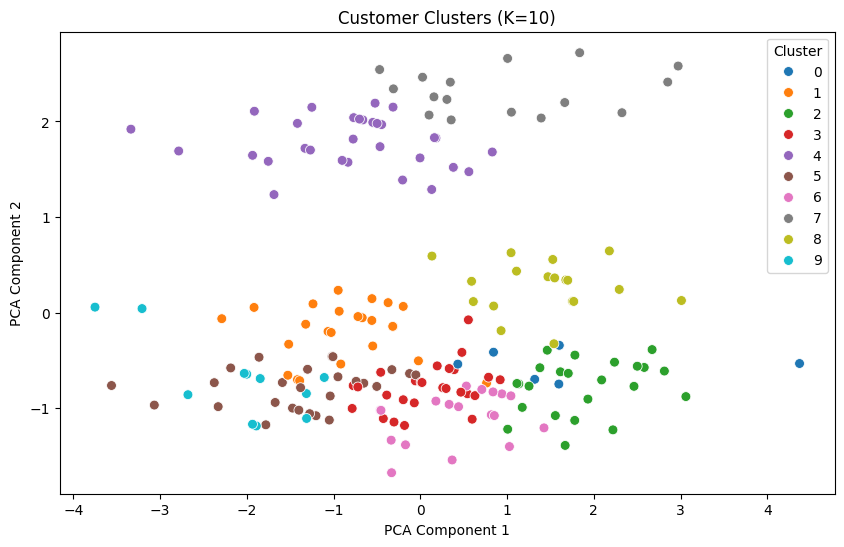

([1.7811799882024357,
  1.5408905857884336,
  1.1926430643192663,
  1.0817231242991745,
  1.0917340458691411,
  1.021357736903317,
  0.9649533093500907,
  0.9828243140122763,
  0.9616777701551935],
 [0.21366401006676053,
  0.26058843637496004,
  0.31973356884457993,
  0.3386932977654135,
  0.30673706544867546,
  0.3475902941480446,
  0.36854489742625884,
  0.365752323747887,
  0.3673509535087034],
 10,
 0.9616777701551935)

In [6]:

# Visualize clusters using PCA (2D reduction)
pca = PCA(n_components=2)
customer_data_pca = pca.fit_transform(customer_data_scaled)
customer_data['PCA1'] = customer_data_pca[:, 0]
customer_data['PCA2'] = customer_data_pca[:, 1]

# Plot PCA-based clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_data, x='PCA1', y='PCA2', hue='Cluster', palette='tab10', s=50)
plt.title(f'Customer Clusters (K={optimal_clusters})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# Save metrics and clustering details
db_index_final = min(dbi_scores)
dbi_scores, silhouette_scores, optimal_clusters, db_index_final